In [1]:
include("../src/HPFEM.jl")

INFO: Recompiling stale cache file /home/pjabardo/.julia/lib/v0.4/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /home/pjabardo/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /home/pjabardo/.julia/lib/v0.4/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /home/pjabardo/.julia/lib/v0.4/Colors.ji for module Colors.


HPFEM

In [25]:
nel = 10
nnodes = nel + 1
idir = [1,nnodes]
M = 5
Q = M
lagr = HPFEM.Lagrange1d(M)
quad = HPFEM.QuadType(Q)
#bas = HPFEM.Basis1d(lagr, quad)
bas = HPFEM.SEM1d(M) 
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [26]:
lmap

HPFEM.LocalNumSys1d(2,3,[1,5],[2,3,4])

In [27]:
uexact(x) = sin(x)
rhsfun(x) = 2*sin(x)


rhsfun (generic function with 1 method)

In [28]:
a = 1.0
b = 15.0
nodes = collect(linspace(a, b, nnodes));

In [29]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [30]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBSymTri);

In [31]:
for e = 1:nel
    Ae = zeros(M, M)
    HPFEM.add_stiff_matrix!(bas, elems[e], Ae)
    HPFEM.add_mass_matrix!(bas, elems[e], Ae)
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [32]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = rhsfun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
Fe[1,1] = uexact(a);
Fe[M,nel] = uexact(b);

In [33]:
HPFEM.solve!(solver, Fe);

In [34]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;

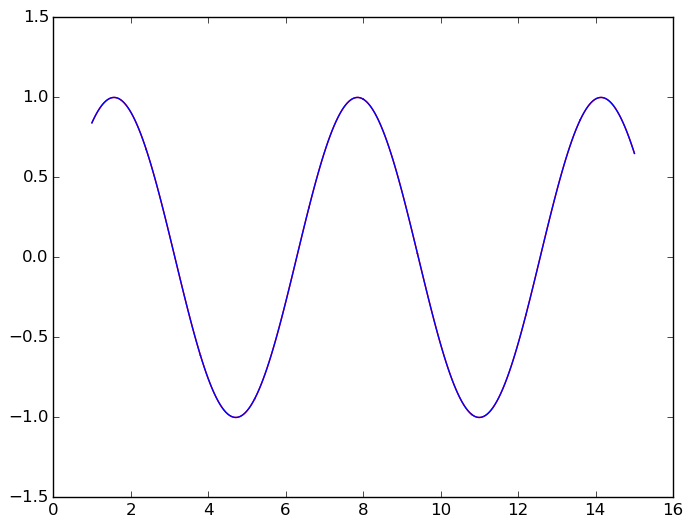

0.00013114961949486914

In [35]:
using PyPlot
maxerr = 0.0
for e = 1:nel
    el = elems[e]
    x = (1-ξ)*el.a/2 + (1+ξ)*el.b/2 
    uu = uexact(x)
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(x, Ue[:,e], "r", x, uu, "b")
end
maxerr